In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Lab 1

In [48]:
# UTILITIES

def plot_series(time, series, start=0, end=None, format="-"):
  if type(series) is tuple:
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)
  plt.legend(["Ground Truth", "Fucking Predicted"])
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True) 
  plt.show()

def trend(time, slope):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(season_time*3))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  data_pattern = amplitude*seasonal_pattern(season_time)
  return data_pattern

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

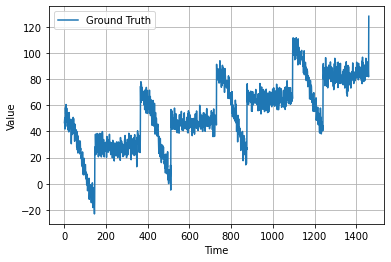

In [49]:
# GENERATING SYNTHETIC DATA

time = np.arange(4*365+1, dtype="float32")
baseline = 10
amplitude= 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope)

series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level)

plot_series(time, series)

In [50]:
# SPLIT DATASET

def train_val_split(time, series, split_time):
  train_time = time[:split_time] 
  test_time = time[split_time:]

  train_series = series[:split_time]
  test_series = series[split_time:]

  return train_time, test_time, train_series, test_series

train_time, test_time, train_series, test_series = train_val_split(time, series, split_time=1000)

In [51]:
# PREPARE FEATURES AND LABELS BY WINDOWING

# parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size=window_size, batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.map(lambda w: (w[:-1], w[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(train_series)

for w in dataset.take(1):
  print("feature: ", w[0].shape)
  print("label: ", w[1].shape)

feature:  (32, 20)
label:  (32,)


In [52]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40), 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0),
])
# metrics=["mae"]
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.9))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 25.5571 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 24.9777 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 24.3774 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 23.7412 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 23.0742 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 22.3687 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 21.6290 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 20.8757 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 20.0970 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 19.2730 - lr: 2.8184e-08
Epoch 11/

(1e-07, 0.0001, 0.0, 20.0)

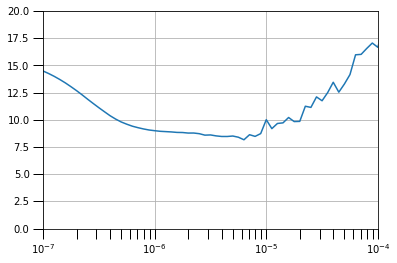

In [53]:
lrs = 1e-8 * (10**((np.arange(100))/20))

plt.semilogx(lrs, history.history["loss"])
plt.grid(True)
# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

In [54]:
np.argmin(history.history["loss"])

56

In [57]:
(history.history["loss"])[56]

8.161344528198242

In [58]:
history.history["lr"][56]

6.3095736e-06

In [25]:
model_last = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40), 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100),
])

model_last.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6))

history2 = model_last.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 77.3905
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 43.3468
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 26.6174
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 21.8829
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 20.0879
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 18.9929
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 18.3250
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.8958
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 17.5858
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 17.3086
Epoch 11/100
31/31 [==============================] - 0s 10ms/step - loss: 17.0606
Epoch 12/100
31/31 [==============================] - 0s 10ms/step - loss: 16.8300
Epoch 13/100


Text(0, 0.5, 'Loss')

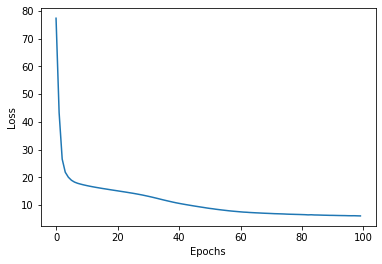

In [26]:
plt.plot(range(len(history2.history["loss"])), history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [27]:
split_time = 1000
forecast = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
  forecast.append(model_last.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 19ms/step


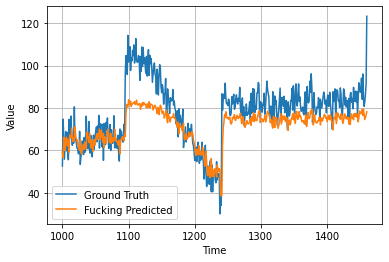

In [28]:
plot_series(test_time, (test_series, results))

In [29]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(test_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_series, results).numpy())

118.630486
8.539716


In [59]:
model_last = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40), 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100),
])

model_last.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=6.3095736e-06))

history2 = model_last.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 11ms/step - loss: 23.3829
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 8.1576
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 7.6636
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 7.5337
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 7.4978
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 7.2625
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 7.2306
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 7.2003
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 7.1094
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 6.9789
Epoch 11/100
31/31 [==============================] - 1s 18ms/step - loss: 6.9818
Epoch 12/100
31/31 [==============================] - 1s 13ms/step - loss: 7.0685
Epoch 13/100
31/31 [====

Text(0, 0.5, 'Loss')

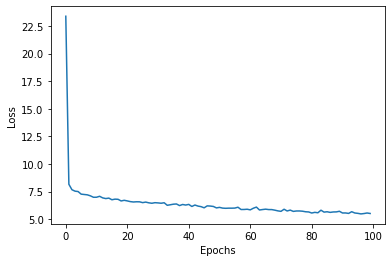

In [60]:
plt.plot(range(len(history2.history["loss"])), history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [61]:
split_time = 1000
forecast = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
  forecast.append(model_last.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 20ms/step


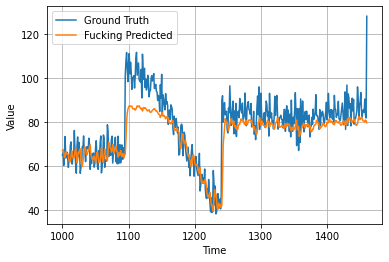

In [62]:
plot_series(test_time, (test_series, results))

In [63]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(test_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_series, results).numpy())

81.404655
6.6098876


# Lab 2

In [78]:
tf.keras.backend.clear_session()

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0),
])

model_lstm.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.Huber())

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

history = model_lstm.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 9s 32ms/step - loss: 100.5048 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 31ms/step - loss: 100.3397 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 100.1567 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 99.9537 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 99.7279 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 99.4761 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 30ms/step - loss: 99.1951 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 98.8810 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 30ms/step - loss: 98.5292 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 98.1345 - lr: 2.8184e-08
Epoch 

Text(0, 0.5, 'Loss')

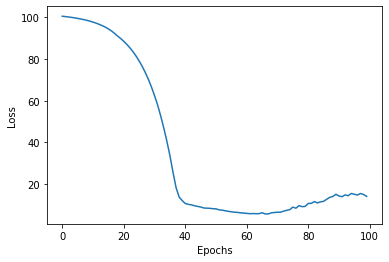

In [79]:
plt.plot(range(len(history.history["loss"])), history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [80]:
np.argmin(history.history["loss"])

66

In [81]:
history.history["lr"][66]

1.9952624e-05

(1e-08, 0.01, 0.0, 20.0)

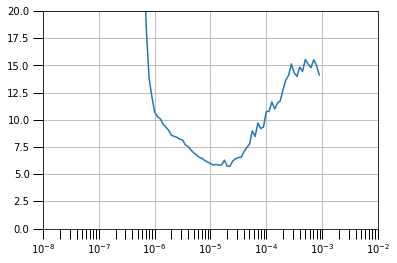

In [83]:
lrs = 1e-8 * (10**((np.arange(100))/20))

plt.semilogx(lrs, history.history["loss"])
plt.grid(True)
# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-2, 0, 20])

In [84]:
tf.keras.backend.clear_session()

model_lstm2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0),
])

model_lstm2.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.Huber())

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

history2 = model_lstm2.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 11s 32ms/step - loss: 14.7105 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 2s 52ms/step - loss: 14.6982 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 2s 49ms/step - loss: 14.6848 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 14.6697 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 2s 62ms/step - loss: 14.6528 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 2s 35ms/step - loss: 14.6338 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 33ms/step - loss: 14.6129 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 32ms/step - loss: 14.5893 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 31ms/step - loss: 14.5632 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 14.5340 - lr: 2.8184e-08
Epoch 11

Text(0, 0.5, 'Loss')

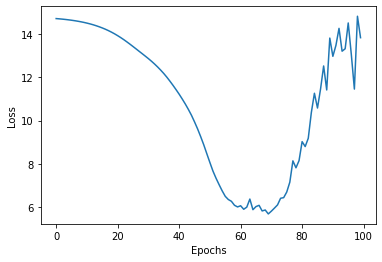

In [85]:
plt.plot(range(len(history2.history["loss"])), history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [86]:
forecasts = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series) - window_size):
  forecasts.append(model_lstm2.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecasts).squeeze()

1/1 [==============================] - 0s 24ms/step


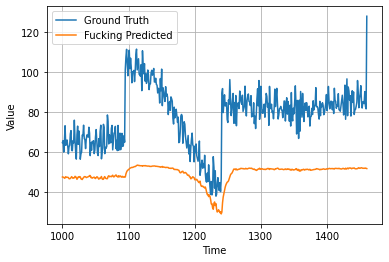

In [88]:
plot_series(test_time, (test_series, results))

In [90]:
# stop 60 epochs
tf.keras.backend.clear_session()

model_lstm3 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0),
])

model_lstm3.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.Huber())

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

history3 = model_lstm3.fit(dataset, epochs=60, callbacks=[lr_schedule])

Epoch 1/60
31/31 [==============================] - 8s 30ms/step - loss: 18.4768 - lr: 1.0000e-08
Epoch 2/60
31/31 [==============================] - 1s 30ms/step - loss: 18.4185 - lr: 1.1220e-08
Epoch 3/60
31/31 [==============================] - 2s 55ms/step - loss: 18.3536 - lr: 1.2589e-08
Epoch 4/60
31/31 [==============================] - 3s 93ms/step - loss: 18.2830 - lr: 1.4125e-08
Epoch 5/60
31/31 [==============================] - 2s 60ms/step - loss: 18.2048 - lr: 1.5849e-08
Epoch 6/60
31/31 [==============================] - 1s 30ms/step - loss: 18.1194 - lr: 1.7783e-08
Epoch 7/60
31/31 [==============================] - 1s 29ms/step - loss: 18.0262 - lr: 1.9953e-08
Epoch 8/60
31/31 [==============================] - 1s 30ms/step - loss: 17.9253 - lr: 2.2387e-08
Epoch 9/60
31/31 [==============================] - 1s 30ms/step - loss: 17.8155 - lr: 2.5119e-08
Epoch 10/60
31/31 [==============================] - 1s 30ms/step - loss: 17.6972 - lr: 2.8184e-08
Epoch 11/60
31/31 [

Text(0, 0.5, 'Loss')

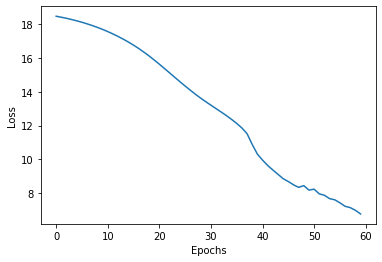

In [92]:
plt.plot(range(len(history3.history["loss"])), history3.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [93]:
forecasts = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series) - window_size):
  forecasts.append(model_lstm3.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecasts).squeeze()

1/1 [==============================] - 0s 21ms/step


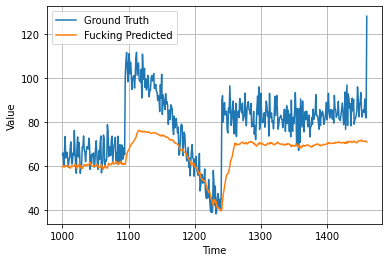

In [94]:
plot_series(test_time, (test_series, results))

## with best model and val set

In [96]:
val_set = windowed_dataset(test_series)

In [97]:
tf.keras.backend.clear_session()

model_best = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40), 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100),
])

model_best.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=6.3095736e-06), metrics=["mae"])

historyy = model_best.fit(dataset, epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 3s 34ms/step - loss: 71.0149 - mae: 71.5114 - val_loss: 35.7459 - val_mae: 36.2433
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 14.4408 - mae: 14.9321 - val_loss: 32.2534 - val_mae: 32.7522
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 11.9152 - mae: 12.4044 - val_loss: 22.5556 - val_mae: 23.0538
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 10.4199 - mae: 10.9044 - val_loss: 18.5307 - val_mae: 19.0280
Epoch 5/100
31/31 [==============================] - 1s 15ms/step - loss: 9.6980 - mae: 10.1858 - val_loss: 16.6217 - val_mae: 17.1154
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 9.0073 - mae: 9.4904 - val_loss: 15.8552 - val_mae: 16.3478
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 8.5179 - mae: 8.9989 - val_loss: 13.0443 - val_mae: 13.5382
Epoch 8/100
31/31 [==============================] - 

Text(0, 0.5, 'Loss')

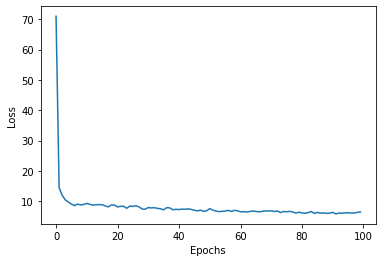

In [99]:
plt.plot(range(len(historyy.history["loss"])), historyy.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [100]:
forecasts = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series) - window_size):
  forecasts.append(model_best.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecasts).squeeze()

1/1 [==============================] - 0s 21ms/step


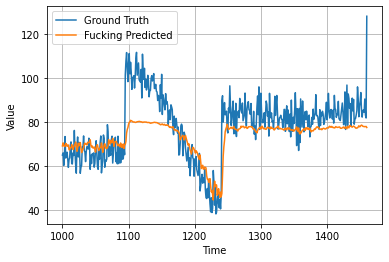

In [101]:
plot_series(test_time, (test_series, results))

In [103]:
tf.keras.metrics.mean_absolute_error(test_series, results).numpy()
# error recovered from 8.53 to 8.35

8.359991